# 3. Feature Engineering, Extraction and Selection

## Inporting Dependencies

In [250]:
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import json
import re
import nltk
from nltk.stem  import WordNetLemmatizer
from prettytable import PrettyTable
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [251]:
# nltk.download('vader_lexicon')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# nltk.download("stopwords")
# nltk.download('tagsets')
# nltk.download('wordnet')

In [252]:
plt.style.use('ggplot')

In [253]:
df = pd.read_csv('G:/Il mio Drive/MAGISTRALE/IT Coding/Project/Sentiment-Analysis-on-Amazon-product-reviews/Data/after_EDA_revs.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head(3)

,Clean Review,Review,Title,Content,Rating,Sentiment,Year,Month,Day,TB Polarity,Review Length,Word Count
0,good sound seem decent build quality good soun...,good sound. seem decent build quality and good...,good sound,seem decent build quality and good sound. very...,5,Positive,2023,5,28,0.561111,79,13
1,not realise bad audio setup considering used q...,i didn't realise how bad my audio setup was. c...,i didn't realise how bad my audio setup was,considering i used to have quite a respectable...,5,Positive,2023,5,27,0.256481,521,94
2,beauty love compact shape sound,its a beauty. love its compact shape and sound,its a beauty,love its compact shape and sound,5,Positive,2023,5,26,0.450000,46,9


Extraction:
- tdidf vectorizer
- feature importance with unigram, bigram and trigram

Selection:
- Chi Square test

## Feature Engineering

- Lemmatize all clean reviews
- Encoding sentiment's labels
- Word Embedding: TD-IDF Vectorizer
- SMOTE for sample imbalance

### Lemmatization

In this part I am going to define a function which will **lemmatize** all the words in the sentences of the 'Clean Review' column. 

But what does lemmatize mean? A lemma is a word that represents a whole group of words, so lemmatizing consists in reducing  words to their core meaning (doing -> do). Lemmatization generally has higher accuracy than another technique called Stemming. Lemmatization is preferred for context analysis, whereas stemming is recommended when the context is not important. Stemming is the process of reducing the inflected form of a word to its root form.

For this function I firstly used nltk word_toknenize() and pos_tag() methods to split the sentence in a list words (a.k.a. feature vector) with their respective tag. Then I proceeded to check which words the WordNetLemmatizer() could lemmatize (adjectives, nouns, adverbs and verbs), lemmatizing the words in the sentence based on their POS tags and returning the list of lemmatized words. To do that I extracted the first letter of the tag and converted it to lower case in order to use that variable in the lemmatizer.

POS tags: 
- "a" refers to adjectives
- "r" refers to adverbs
- "n" refers to nouns
- "v" refers to verbs

In [254]:
# here we can find the meaning of all the tags
# nltk.help.upenn_tagset()

In [255]:
def lemmatize(sentence):
    lemmatizer = WordNetLemmatizer()                                # define the lemmatizer

    tokens = nltk.word_tokenize(sentence)                           # tokenize sentence
    tags = nltk.pos_tag(tokens)                                     # tag each token
    list_of_tags = ['JJ', 'JJR', 'JJS',                             # adjectives
                    'NN', 'NNP', 'NNPS', 'NNS',                     # nouns
                    'RB', 'RBR', 'RBS',                             # adverbs
                    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']        # verbs

    lemmatized_sentence = ""
    for t in tags:
        if t[1] in list_of_tags:
            pos = t[1].lower()[0]
            if t[1][0] == 'J':
                pos = 'a'                                           # according to the 4 different pos values
        else:
            pos = None      # invariant words

        if pos != None:
            lemma = lemmatizer.lemmatize(t[0], pos=pos)
        else:
            lemma = t[0]
        lemmatized_sentence += " " + lemma                           # build the lemmatized sentence
    return lemmatized_sentence

In [256]:
df['Clean Review'] = df['Clean Review'].apply(lemmatize)
df.head(3)

,Clean Review,Review,Title,Content,Rating,Sentiment,Year,Month,Day,TB Polarity,Review Length,Word Count
0,good sound seem decent build quality good sou...,good sound. seem decent build quality and good...,good sound,seem decent build quality and good sound. very...,5,Positive,2023,5,28,0.561111,79,13
1,not realise bad audio setup consider use quit...,i didn't realise how bad my audio setup was. c...,i didn't realise how bad my audio setup was,considering i used to have quite a respectable...,5,Positive,2023,5,27,0.256481,521,94
2,beauty love compact shape sound,its a beauty. love its compact shape and sound,its a beauty,love its compact shape and sound,5,Positive,2023,5,26,0.450000,46,9


### Encoding sentiment's labels

Here I'm using the label encoder to convert the values (Positive, Negative, Neutral) of the Sentiment Feature into numbers.

In [257]:
encoder = LabelEncoder()

In [258]:
df['Target'] = encoder.fit_transform(df['Sentiment'])
df['Target'].unique()

array([2, 0, 1])

- 2 is Positive
- 1 is Neutral
- 0 is Negative

In [259]:
df['Target'].value_counts()

2    643
0     66
1     31
Name: Target, dtype: int64

As we already know from the EDA, there is a huge class imbalance in the Target variable. Therefore, after the Word Embedding stage, we can use a little "trick" to re-balance the classes called SMOTE.

### TD-IDF 

The aim of this section is to embed the words in each corpus. In very simple terms, **Word Embeddings** are the texts converted into numbers and there may be different numerical representations of the same text. In fact there are different types of word embeddings - One Hot Encoding, the CountVectorizer, Bag Of Words (BOW), N-grams and TD-IDF vectorization - and in this case I am going to use the TD-IDF one.

Term Frequency - Inverse Document Frequency (TF-IDF) gives a measure that takes the importance of a word into consideration depending on how frequently it occurs in a document and a corpus. The formula for finding TF-IDF is the following:
$$W_{x,y} = tf_{x,y}log(\frac{N}{df_{x}})$$
Where:
- W is the word x within the review y
- tf is the term frequency of x in y
- df is the number of reviews containing x
- N is the total number of reviews

In [260]:
vect = TfidfVectorizer()
X = vect.fit_transform(df['Clean Review'])

In [261]:
X.shape

(740, 3106)

We obtained a sparse matrix of 740 reviews x 3106 words. Basically this a matrix where every column is a word and the values are the "impact" that each particular word has on the entire review. Let's visualize the features-words and the matrix.

In [262]:
print(vect.get_feature_names())

['00', '000uf', '05', '07', '10', '100', '1000', '100hz', '100w', '104', '109', '10mm', '10s', '11', '116', '12', '1202usb', '120hz', '129', '12ft', '12th', '13', '130', '139', '13a', '13th', '14', '145', '15', '150', '150hz', '15mm', '16', '160', '17', '180', '18th', '19', '192', '1byone', '1k', '20', '200', '2012', '2016', '2019', '2020', '2021', '2022', '2023', '2030', '20hz', '20x', '23', '24c', '24ft', '25', '250', '250ohm', '25w', '2db', '2i2', '2i4', '2k', '2m', '2nd', '2w', '30', '300', '300mv', '3030i', '3045', '305ps', '30hz', '30pm', '31', '33', '34', '35', '35mm', '3k', '3m', '3meters', '3rd', '3x3m', '3x6m', '40', '400', '43', '45', '450', '4m', '4th', '50', '500', '50cm', '50hz', '50s', '50w', '5a', '5bt', '5ft', '5m', '5min', '5mm', '5s', '5x', '60', '600', '60hz', '60s', '643', '66', '69', '6db', '6inch', '6s', '70', '700', '70hz', '70s', '7265', '75th', '76', '770', '78', '79', '7s', '80', '80hz', '83', '85', '87', '8740', '88', '89', '8inch', '8m', '90', '9023', '9038

In [263]:
print(X.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(Here a small curiosity I had: I have now a hig dimensional matrix and it could be fun if I could visualize it in 2 dimensions. I recently had interest in analyzing different dimensionality reduction techniques in terms of preservation of global variance and in terms of visualization. Therefore I wanted to try and visualize the points using t-SNE and UMAP which are way better than PCA  when interested in visualization.)

In [264]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

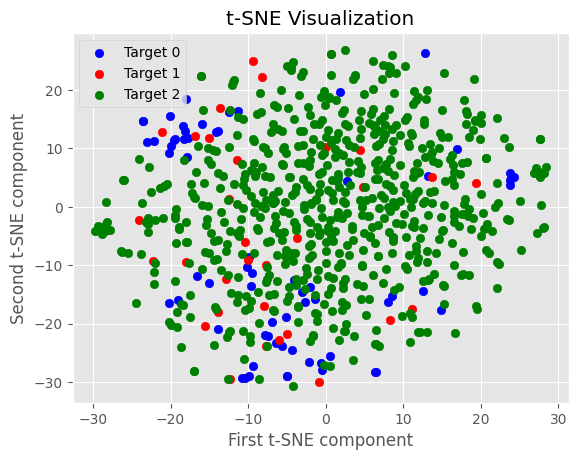

In [265]:
# Plot the t-SNE embeddings with colors based on the target variable
target_colors = ['blue', 'red', 'green']  # Define colors for each target value
labs = df['Target'].values

for value in set(labs):
    plt.scatter(
        X_embedded[labs == value, 0],
        X_embedded[labs == value, 1],
        color=target_colors[value],
        label=f"Target {value}"
    )
plt.title("t-SNE Visualization")
plt.xlabel("First t-SNE component")
plt.ylabel("Second t-SNE component")
plt.legend()
plt.show()

In [266]:
import umap.umap_ as umap

umap_emb = umap.UMAP(n_components=2, random_state=42)
X_embedded_umap = umap_emb.fit_transform(X.toarray())

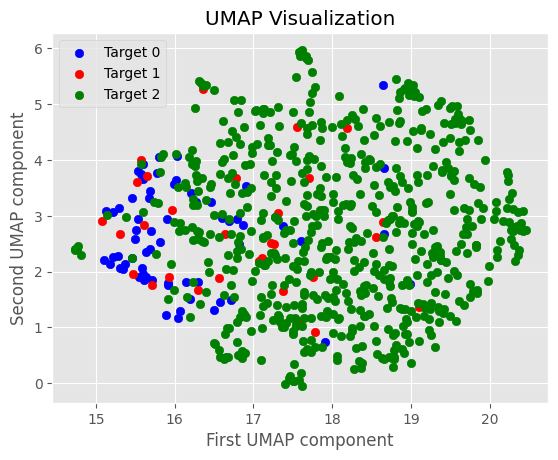

In [267]:
target_colors = ['blue', 'red', 'green']
target_labels = df['Target'].values

for value in set(target_labels):
    plt.scatter(
        X_embedded_umap[target_labels == value, 0],
        X_embedded_umap[target_labels == value, 1],
        color=target_colors[value],
        label=f"Target {value}"
    )

plt.title("UMAP Visualization")
plt.xlabel("First UMAP component")
plt.ylabel("Second UMAP component")
plt.legend()
plt.show()

In [268]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_embedded_pca = pca.fit_transform(X.toarray())

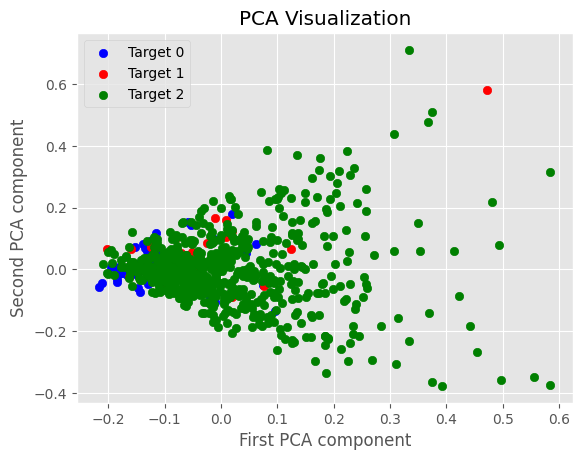

In [269]:
target_colors = ['blue', 'red', 'green']
target_labels = df['Target'].values

for value in set(target_labels):
    plt.scatter(
        X_embedded_pca[target_labels == value, 0],
        X_embedded_pca[target_labels == value, 1],
        color=target_colors[value],
        label=f"Target {value}"
    )

plt.title("PCA Visualization")
plt.xlabel("First PCA component")
plt.ylabel("Second PCA component")
plt.legend()
plt.show()


In [270]:
from mpl_toolkits.mplot3d import Axes3D

# Apply t-SNE to the sparse matrix with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

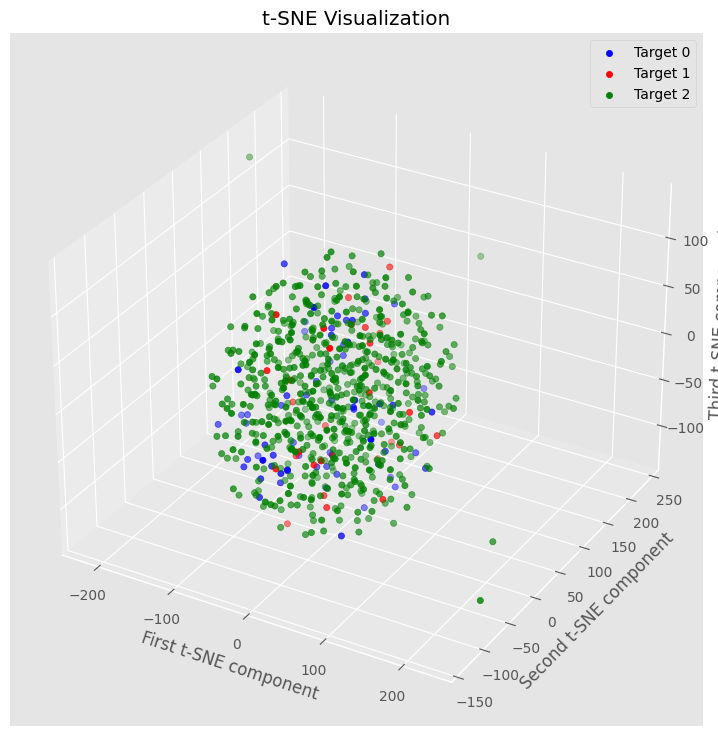

In [271]:
target_colors = ['blue', 'red', 'green']  # Define colors for each target value
labs = df['Target'].values

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

for value in set(labs):
    ax.scatter(
        X_embedded[labs == value, 0],
        X_embedded[labs == value, 1],
        X_embedded[labs == value, 2],  # Add the third dimension of t-SNE embeddings
        color=target_colors[value],
        label=f"Target {value}"
    )

ax.set_title("t-SNE Visualization")
ax.set_xlabel("First t-SNE component")
ax.set_ylabel("Second t-SNE component")
ax.set_zlabel("Third t-SNE component")
ax.legend()
plt.show()

Unfortunately we can't draw some interesting insights: we can for sure say that the all reviews are pretty much aggregated in a single big cluster with some positive reviews outliers. The class imbalance is again clear.

### SMOTE

It is crucial to balance the classes in such situation. Here I use SMOTE(Synthetic Minority Oversampling Technique) to solve this problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them.

SMOTE synthesises new minority instances between existing minority instances: it basically generates new synthetic training records by randomly selecting one or more of the k-nearest neighbors for each example in the minority class.

In [272]:
df['Target'].value_counts()

2    643
0     66
1     31
Name: Target, dtype: int64

Showing again the class imbalance for informative purposes.

In [273]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'After SMOTE, the shape of Target is: {Counter(y_res)}')

NameError: name 'SMOTE' is not defined

## VADER


compound of vader is 10x better than the textblob polarities

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia

In [ ]:
# run on entire dataset
results = {}
for i, row in df.iterrows():
    text = row['Review']
    Id = i
    results[Id] = sia.polarity_scores(text)

In [ ]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index': 'Id',
                                              'neg': 'Vaders neg',
                                              'neu': 'Vaders neu',
                                              'pos': 'Vaders pos',
                                              'compound': 'Vaders compound'})

df['Id'] = range(df.shape[0])
vaders = vaders.merge(df, how='left')
vaders.head(1)

,Id,Vaders neg,Vaders neu,Vaders pos,Vaders compound,Clean Review,Review,Title,Content,Rating,Sentiment,Year,Month,Day,TB Polarity,Review Length,Word Count,Target
0,0,0.0,0.505,0.495,0.8687,"[good, sound, seem, decent, build, quality, go...",good sound. seem decent build quality and good...,good sound,seem decent build quality and good sound. very...,5,Positive,2023,5,28,0.561111,79,13,2


Compound is an aggregation of the 3, goes from -1 to 1.

Is this in line with what we expect? If the rating is 5-4, is the rating positive?

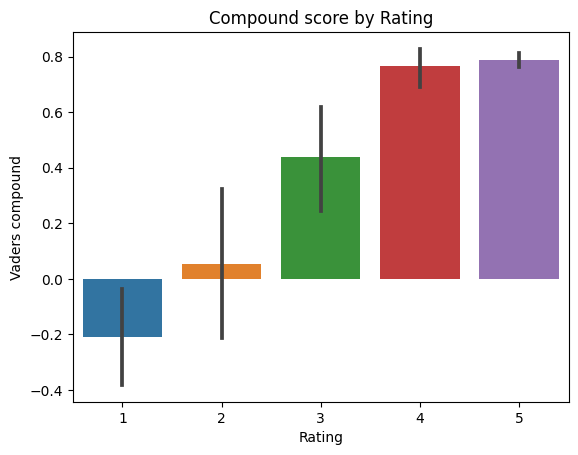

In [ ]:
ax = sns.barplot(data=vaders, x='Rating', y='Vaders compound')
ax.set_title('Compound score by Rating')
plt.show()

It is what we would expect!

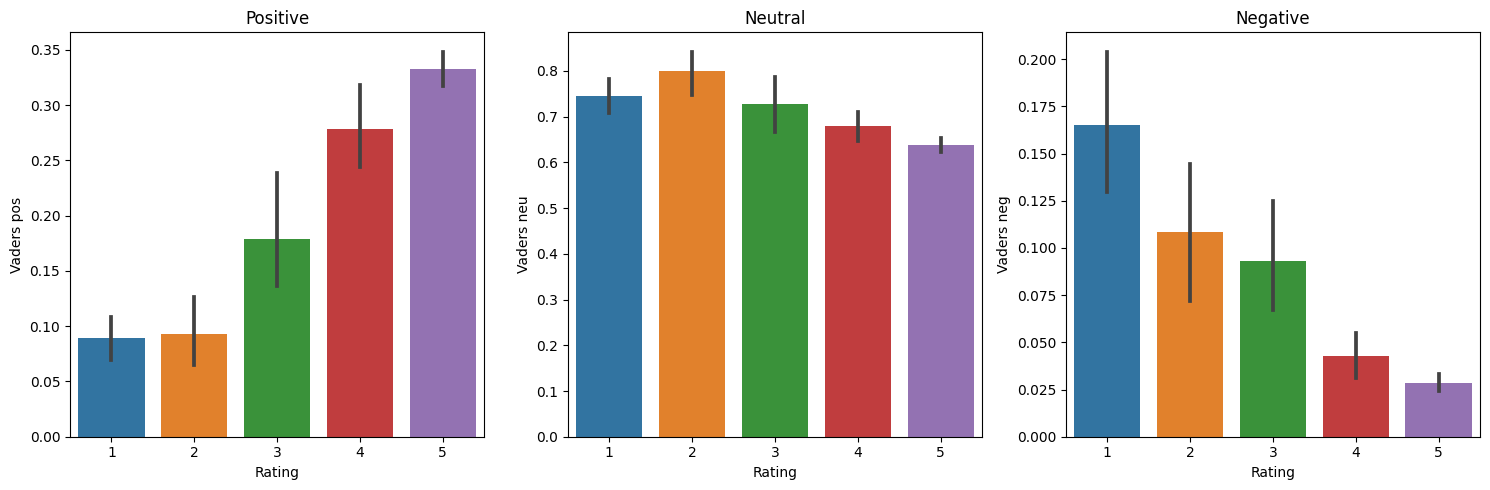

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data = vaders, x='Rating', y='Vaders pos', ax = axs[0])
sns.barplot(data = vaders, x='Rating', y='Vaders neu', ax = axs[1])
sns.barplot(data = vaders, x='Rating', y='Vaders neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## RoBERTa

### The Transformers Pipeline

In [ ]:
# from transformers import pipeline

# sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline = ('phrase')